Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path

# Plotting
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')
import copy

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from plotting_functions import *
from synthetic_grid_cells import GridModule, rotation_matrix
from methods import multiimshow, PCA_UMAP, filenames
from Experiment import Experiment
from stats import *

In [3]:
#base_path = Path("/storA/GridCells/")
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()
paths = experiment.paths
boxsize = experiment.environments[0].boxsize
extent = [-boxsize[0] / 2, boxsize[0] / 2, -boxsize[1] / 2, boxsize[1] / 2]
f = 1/0.856#1/0.78
default = GridModule(1,orientation_offset=0, center=np.zeros(2), f=f)

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
nx,ny = 2.2,2.2 # board size
boxsize=(nx,ny)
res = 200

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, res),
    np.linspace(-ny/2, ny/2, res),
)
board = np.stack([xx, yy], axis=-1)

In [5]:
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices_new.npz")
#module_indices = np.load(f"{experiment.paths['experiment']}/module_indices.npz")
print(module_indices.files)
module_indices = module_indices['C0_from_env_2']
#module_indices = module_indices['C5_from_env_2']
ncells = len(module_indices)

['C0_from_env_2']


In [6]:
ratemaps = []
for env_i in range(3):
    with open(paths['ratemaps'] / (f'env_{env_i}/' + filenames(paths['ratemaps'] / f'env_{env_i}')[-1]), 'rb') as f:
        tmp_ratemaps = pickle.load(f)[module_indices]
        # fix nans
        tmp_ratemaps = np.array([fill_nan(ratemap, method='nearest') for ratemap in tmp_ratemaps])
        ratemaps.append(tmp_ratemaps)
ratemaps = np.stack(ratemaps)

(<Figure size 900x600 with 1 Axes>, <Axes: >)

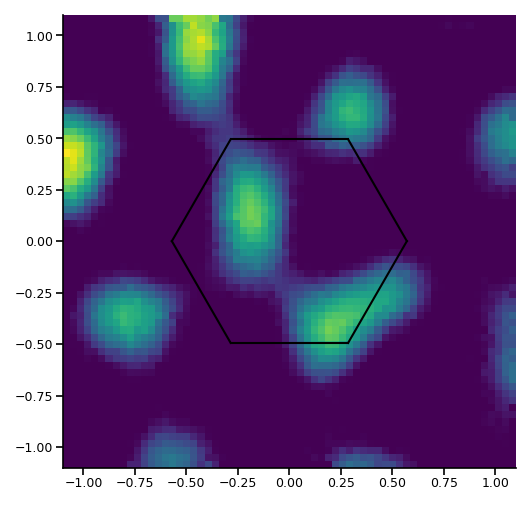

In [7]:
fig,ax = plt.subplots()
ax.imshow(ratemaps[0,0], origin="lower", extent=extent)
default.unit_cell.plot(fig,ax, color="k", linewidth=1)

(0.7847436685609097, 0.018874353659086185)


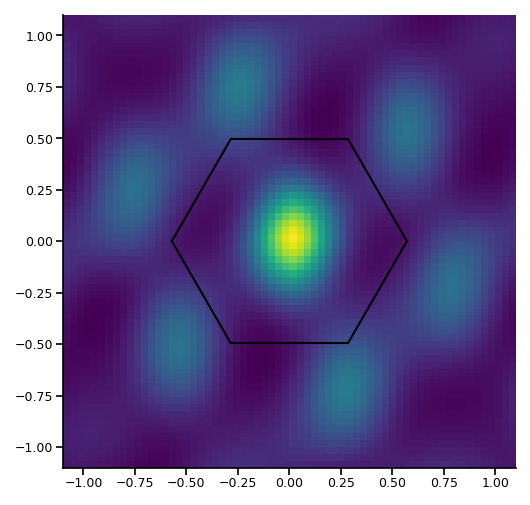

In [8]:
fig,ax = plt.subplots()
ax.imshow(correlate(ratemaps[0,0], ratemaps[0,0], mode='same'), origin="lower", extent=extent)
default.unit_cell.plot(fig,ax, color="k", linewidth=1)
print(grid_spacing(ratemaps[0,0]))

## Phase shift statistics

In [9]:
phase_shifts01 = np.array([calculate_phase_shift(ratemaps[0,i],ratemaps[1,i],boxsize=boxsize) for i in range(ncells)])
phase_shifts02 = np.array([calculate_phase_shift(ratemaps[0,i],ratemaps[2,i],boxsize=boxsize) for i in range(ncells)])
phase_shifts12 = np.array([calculate_phase_shift(ratemaps[1,i],ratemaps[2,i],boxsize=boxsize) for i in range(ncells)])
phase_shifts01 = phase_shifts01[np.isnan(phase_shifts01.sum(-1))==False]
phase_shifts02 = phase_shifts02[np.isnan(phase_shifts02.sum(-1))==False]
phase_shifts12 = phase_shifts12[np.isnan(phase_shifts12.sum(-1))==False]
print(ncells, len(phase_shifts01), len(phase_shifts02), len(phase_shifts12))

375 373 373 373


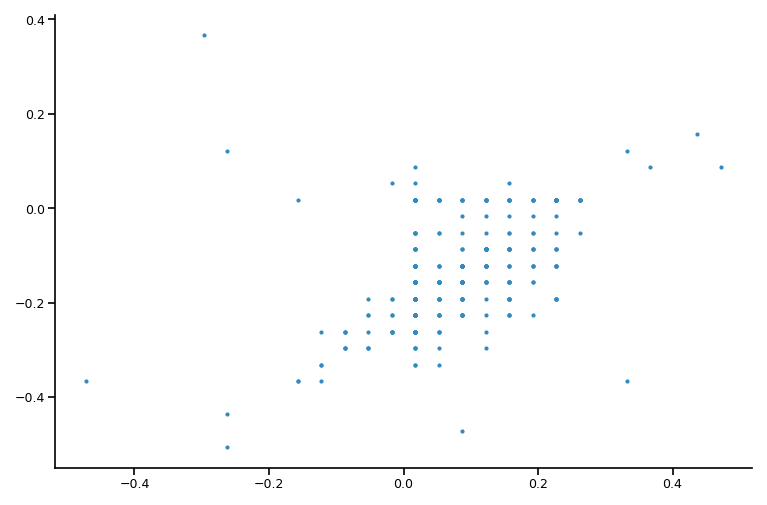

In [10]:
plt.scatter(*phase_shifts01.T, s=1)

In [11]:
from scipy.stats import gaussian_kde

bw_method = 0.1
phase_shifts01_kde = gaussian_kde(phase_shifts01.T)#, bw_method=bw_method)
phase_shifts02_kde = gaussian_kde(phase_shifts02.T)#, bw_method=bw_method)
phase_shifts12_kde = gaussian_kde(phase_shifts12.T)#, bw_method=bw_method)
phase_shifts01_map = phase_shifts01_kde(board.reshape(-1,2).T).reshape(res,res)
phase_shifts02_map = phase_shifts02_kde(board.reshape(-1,2).T).reshape(res,res)
phase_shifts12_map = phase_shifts12_kde(board.reshape(-1,2).T).reshape(res,res)
vmin,vmax = np.min([phase_shifts01_map,phase_shifts02_map,phase_shifts12_map]), np.max([phase_shifts01_map,phase_shifts02_map,phase_shifts12_map])

In [12]:
panesize = set_size(width=345, mode='square')
panesize

figsize=(panesize[0]/3,panesize[1]/3)
figsize=np.array(figsize)

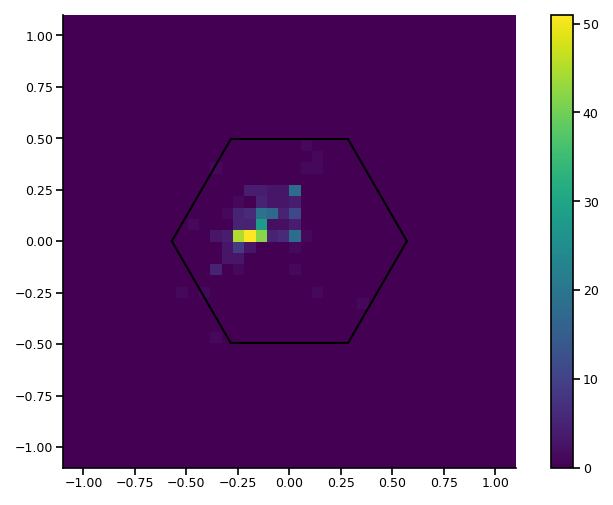

In [13]:
hist = scipy.stats.binned_statistic_2d(*phase_shifts01.T,values=np.empty_like(phase_shifts01[:,0]),
statistic="count",bins=40,range=[[-nx/2,nx/2],[-ny/2,ny/2]]).statistic

fig,ax = plt.subplots()
ax.imshow(hist, origin='lower', extent=[-nx/2,nx/2,-ny/2,ny/2])
default.unit_cell.plot(ax=ax, color='k', linewidth=1)
# add colorbar
cbar = fig.colorbar(ax.images[0], ax=ax)

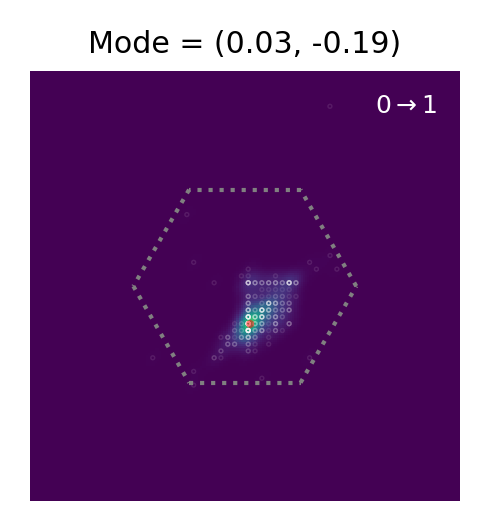

In [28]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
im = ax.imshow(phase_shifts01_map, origin='lower', extent=[-nx/2, nx/2, -ny/2, ny/2], vmin=vmin, vmax=vmax)
ax.scatter(*phase_shifts01.T, s=0.1, color='white', alpha=0.1, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))
default.unit_cell.plot(ax=ax, color='grey', linewidth=1, ls=':')
ax.axis('off')
ax.legend(["$0 \\rightarrow 1$"])
# change color of the legend to white
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_color("white")

# find the mode of the distribution and plot it
mode01 = np.array(np.unravel_index(np.argmax(phase_shifts01_map, axis=None), phase_shifts01_map.shape))[::-1]
mode01 = mode01 / (np.array(phase_shifts01_map.shape[::-1]) - 1) - 0.5 # normalize to -0.5, 0.5
mode01 = mode01 * np.array([nx, ny]) # scale to the extent of the environment
ax.scatter(*mode01, s=1, color='red', alpha=0.5, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))  # plot the mode
ax.set_title(f"Mode = ({mode01[0]:.2f}, {mode01[1]:.2f})")
# remove whitespace but leave more space for title
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
fig.savefig(experiment.paths['experiment'] / "plots/phase_shifts01")


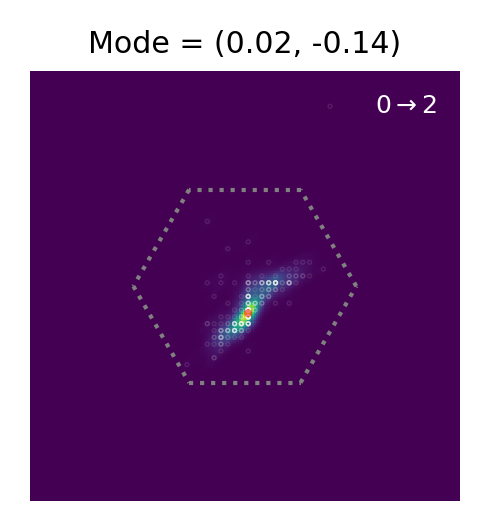

In [29]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
im = ax.imshow(phase_shifts02_map, origin='lower', extent=[-nx/2, nx/2, -ny/2, ny/2], vmin=vmin, vmax=vmax)
ax.scatter(*phase_shifts02.T, s=0.1, color='white', alpha=0.1, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))
default.unit_cell.plot(ax=ax, color='grey', linewidth=1, ls=':')
ax.axis('off')
ax.legend(["$0 \\rightarrow 2$"])
# change color of the legend to white
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_color("white")

# find the mode of the distribution and plot it
mode02 = np.array(np.unravel_index(np.argmax(phase_shifts02_map, axis=None), phase_shifts02_map.shape))[::-1]
mode02 = mode02 / (np.array(phase_shifts02_map.shape[::-1]) - 1) - 0.5 # normalize to -0.5, 0.5
mode02 = mode02 * np.array([nx, ny]) # scale to the extent of the environment
ax.scatter(*mode02, s=1, color='red', alpha=0.5, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))  # plot the mode
ax.set_title(f"Mode = ({mode02[0]:.2f}, {mode02[1]:.2f})")
# remove whitespace but leave more space for title
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
fig.savefig(experiment.paths['experiment'] / "plots/phase_shifts02")


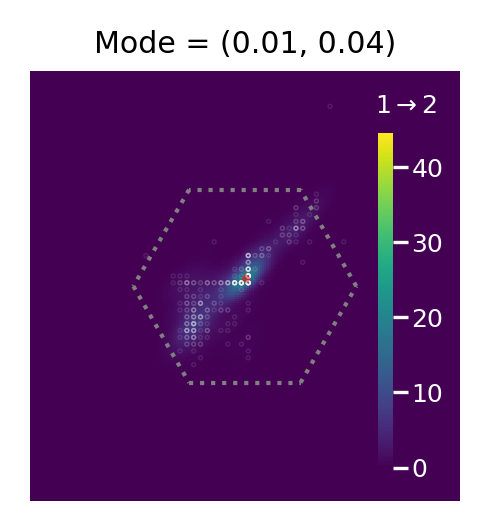

In [30]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
im = ax.imshow(phase_shifts12_map, origin='lower', extent=[-nx/2, nx/2, -ny/2, ny/2], vmin=vmin, vmax=vmax)
ax.scatter(*phase_shifts12.T, s=0.1, color='white', alpha=0.1, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))
default.unit_cell.plot(ax=ax, color='grey', linewidth=1, ls=':')
ax.axis('off')
ax.legend(["$1 \\rightarrow 2$"])
# change color of the legend to white
leg = ax.get_legend()
for text in leg.get_texts():
    text.set_color("white")

# add colorbar
cax = fig.add_axes([0.78, 0.07, 0.03, 0.7])  # adjust the position and size of the colorbar
cbar = fig.colorbar(im, cax=cax)

# remove colorbar border
cbar.outline.set_visible(False)

# change colorbar tick color
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# find the mode of the distribution and plot it
mode12 = np.array(np.unravel_index(np.argmax(phase_shifts12_map, axis=None), phase_shifts12_map.shape))[::-1]
mode12 = mode12 / (np.array(phase_shifts12_map.shape[::-1]) - 1) - 0.5 # normalize to -0.5, 0.5
mode12 = mode12 * np.array([nx, ny]) # scale to the extent of the environment
ax.scatter(*mode12, s=1, color='red', alpha=0.5, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))  # plot the mode
ax.set_title(f"Mode = ({mode12[0]:.2f}, {mode12[1]:.2f})")
# remove whitespace but leave more space for title
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
fig.savefig(experiment.paths['experiment'] / "plots/phase_shifts12")


## Grid Orientation statistics

In [17]:
orientations01 = np.array([calculate_orientation_shift(ratemaps[0,i], ratemaps[1,i]) for i in range(ncells)])
orientations02 = np.array([calculate_orientation_shift(ratemaps[0,i], ratemaps[2,i]) for i in range(ncells)])
orientations12 = np.array([calculate_orientation_shift(ratemaps[1,i], ratemaps[2,i]) for i in range(ncells)])
# -----------------
# make circular by extending the orientations by +- 30 degrees
#cos_calculated = np.concatenate([cos_calculated,cos_calculated+30*np.pi/180,cos_calculated-30*np.pi/180])
#ios_calculated = np.concatenate([ios_calculated,ios_calculated+30*np.pi/180,ios_calculated-30*np.pi/180])
# -----------------

/home/vemundss/Dropbox/PhD BI-KI/Prosjekter/emergent-grid-cells/notebooks/../src/stats.py:271: RuntimeWarning: invalid value encountered in true_divide
  autocorr1 = autocorr1 / np.sum(autocorr1)
/home/vemundss/Dropbox/PhD BI-KI/Prosjekter/emergent-grid-cells/notebooks/../src/stats.py:272: RuntimeWarning: invalid value encountered in true_divide
  autocorr2 = autocorr2 / np.sum(autocorr2)


-4.512534818941528 -4.512534818941528 -3.50974930362118
KstestResult(statistic=0.176, pvalue=1.724722611287416e-05)
KstestResult(statistic=0.23466666666666666, pvalue=1.8224942324538472e-09)
KstestResult(statistic=0.24533333333333332, pvalue=2.5787162785596417e-10)
MannwhitneyuResult(statistic=64735.0, pvalue=0.057800215969559754)
MannwhitneyuResult(statistic=74798.0, pvalue=0.12915767873403625)
MannwhitneyuResult(statistic=73817.0, pvalue=0.23538405649851613)
WilcoxonResult(statistic=21996.5, pvalue=0.7742030958789962)
WilcoxonResult(statistic=21535.0, pvalue=6.004364227776336e-09)
WilcoxonResult(statistic=22272.5, pvalue=1.61887535444077e-05)
Ttest_indResult(statistic=1.0176095525931912, pvalue=0.3091925700133549)
Ttest_indResult(statistic=9.18684881604753, pvalue=3.9102982697145977e-19)
Ttest_indResult(statistic=8.871230450151874, pvalue=5.266384338474397e-18)


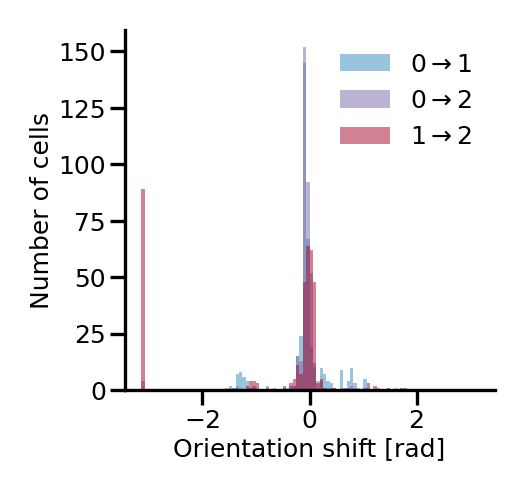

In [31]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
ax.hist(orientations01, bins=100, alpha=0.5, label='$0\\rightarrow 1$', range=[-np.pi,np.pi])
ax.hist(orientations02, bins=100, alpha=0.5, label='$0\\rightarrow 2$', range=[-np.pi,np.pi])
ax.hist(orientations12, bins=100, alpha=0.5, label='$1\\rightarrow 2$', range=[-np.pi,np.pi])
ax.legend()
ax.set_xlabel('Orientation shift [rad]')
ax.set_ylabel('Number of cells')

fig.savefig(experiment.paths['experiment'] / "plots/orientation_shifts")

from scipy.stats import kstest, mannwhitneyu, wilcoxon, ttest_ind
print(np.nanmedian(orientations01)*180/np.pi, np.nanmedian(orientations02)*180/np.pi, np.nanmedian(orientations12)*180/np.pi)
print(kstest(orientations01, orientations02))
print(kstest(orientations01, orientations12))
print(kstest(orientations02, orientations12))
print(mannwhitneyu(orientations01, orientations02))
print(mannwhitneyu(orientations01, orientations12))
print(mannwhitneyu(orientations02, orientations12))
print(wilcoxon(orientations01, orientations02))
print(wilcoxon(orientations01, orientations12))
print(wilcoxon(orientations02, orientations12))
print(ttest_ind(orientations01, orientations02))
print(ttest_ind(orientations01, orientations12))
print(ttest_ind(orientations02, orientations12))

In [19]:
# circularize the orientations
orientations01_circular = copy.deepcopy(orientations01) % (np.pi/6)
orientations02_circular = copy.deepcopy(orientations02) % (np.pi/6)
orientations12_circular = copy.deepcopy(orientations12) % (np.pi/6)
orientations01_circular = np.concatenate([orientations01_circular, orientations01_circular+np.pi/6, orientations01_circular-np.pi/6])
orientations02_circular = np.concatenate([orientations02_circular, orientations02_circular+np.pi/6, orientations02_circular-np.pi/6])
orientations12_circular = np.concatenate([orientations12_circular, orientations12_circular+np.pi/6, orientations12_circular-np.pi/6])

-4.512534818941528 -4.512534818941528 -1.2722218725854067e-14
-3.277325905292499 -2.6745403899721643 -0.005125348189434003
6.449691772426907 4.8560970979621985 4.802897127208728
0.33306065097040544 0.25076777583965015 0.24802054116302463
KstestResult(statistic=0.216, pvalue=4.4953460610571306e-08)
KstestResult(statistic=0.4613333333333333, pvalue=2.2063338633769328e-36)
KstestResult(statistic=0.4186666666666667, pvalue=7.902836299902788e-30)
MannwhitneyuResult(statistic=59417.0, pvalue=0.00021029892902067732)
MannwhitneyuResult(statistic=40604.0, pvalue=9.070732235029525e-24)
MannwhitneyuResult(statistic=44889.0, pvalue=7.350192534330451e-18)
WilcoxonResult(statistic=22354.5, pvalue=0.018464115834783336)
WilcoxonResult(statistic=14970.5, pvalue=1.9664013575100432e-18)
WilcoxonResult(statistic=13561.5, pvalue=9.535510329213953e-19)
Ttest_indResult(statistic=-1.443912096163297, pvalue=0.1491824013451375)
Ttest_indResult(statistic=-7.869308271320414, pvalue=1.2503574279537285e-14)
Ttest_i

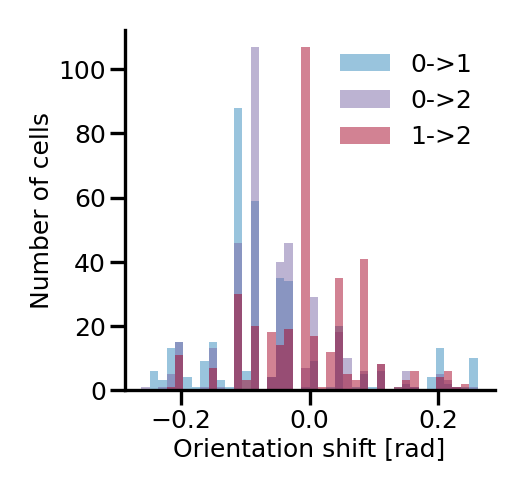

In [32]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)

ax.hist(orientations01_circular, bins=40, alpha=0.5, label='0->1', range=(-np.pi/12,np.pi/12))
ax.hist(orientations02_circular, bins=40, alpha=0.5, label='0->2', range=(-np.pi/12,np.pi/12))
ax.hist(orientations12_circular, bins=40, alpha=0.5, label='1->2', range=(-np.pi/12,np.pi/12))
ax.legend()
mask01 = (orientations01_circular > -np.pi/12) & (orientations01_circular < np.pi/12)
mask02 = (orientations02_circular > -np.pi/12) & (orientations02_circular < np.pi/12)
mask12 = (orientations12_circular > -np.pi/12) & (orientations12_circular < np.pi/12)
print(np.nanmedian(orientations01_circular[mask01])*180/np.pi, np.nanmedian(orientations02_circular[mask02])*180/np.pi, np.nanmedian(orientations12_circular[mask12])*180/np.pi)
#ax.axvline(np.nanmedian(orientations01_circular[mask01]),ls='--')
#ax.axvline(np.nanmedian(orientations02_circular[mask02]),ls='--')
#ax.axvline(np.nanmedian(orientations12_circular[mask12]),ls='--')
ax.set_xlabel('Orientation shift [rad]')
ax.set_ylabel('Number of cells')

fig.savefig(experiment.paths['experiment'] / "plots/orientation_shifts_circular")

# compute mean and standard deviation in degrees
print(np.nanmean(orientations01_circular[mask01])*180/np.pi, np.nanmean(orientations02_circular[mask02])*180/np.pi, np.nanmean(orientations12_circular[mask12])*180/np.pi)
print(np.nanstd(orientations01_circular[mask01])*180/np.pi, np.nanstd(orientations02_circular[mask02])*180/np.pi, np.nanstd(orientations12_circular[mask12])*180/np.pi)

# compute standard error of the mean in degrees
print(np.nanstd(orientations01_circular[mask01])/np.sqrt(np.sum(mask01))*180/np.pi, np.nanstd(orientations02_circular[mask02])/np.sqrt(np.sum(mask02))*180/np.pi, np.nanstd(orientations12_circular[mask12])/np.sqrt(np.sum(mask12))*180/np.pi)

print(kstest(orientations01_circular[mask01], orientations02_circular[mask02]))
print(kstest(orientations01_circular[mask01], orientations12_circular[mask12]))
print(kstest(orientations02_circular[mask02], orientations12_circular[mask12]))
print(mannwhitneyu(orientations01_circular[mask01], orientations02_circular[mask02]))
print(mannwhitneyu(orientations01_circular[mask01], orientations12_circular[mask12]))
print(mannwhitneyu(orientations02_circular[mask02], orientations12_circular[mask12]))
print(wilcoxon(orientations01_circular[mask01], orientations02_circular[mask02]))
print(wilcoxon(orientations01_circular[mask01], orientations12_circular[mask12]))
print(wilcoxon(orientations02_circular[mask02], orientations12_circular[mask12]))
print(ttest_ind(orientations01_circular[mask01], orientations02_circular[mask02]))
print(ttest_ind(orientations01_circular[mask01], orientations12_circular[mask12]))
print(ttest_ind(orientations02_circular[mask02], orientations12_circular[mask12]))

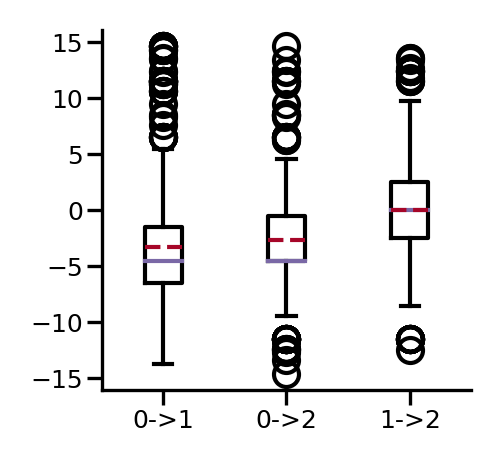

In [21]:
# create boxplot of orientation shifts
fig, ax = plt.subplots(figsize=figsize, dpi=300)
results = plt.boxplot([orientations01_circular[mask01]*180/np.pi, orientations02_circular[mask02]*180/np.pi, 
             orientations12_circular[mask12]*180/np.pi], labels=['0->1', '0->2', '1->2'], meanline=True, showmeans=True);

/home/vemundss/Dropbox/PhD BI-KI/Prosjekter/emergent-grid-cells/notebooks/../src/stats.py:272: RuntimeWarning: invalid value encountered in true_divide
  autocorr2 = autocorr2 / np.sum(autocorr2)
/home/vemundss/Dropbox/PhD BI-KI/Prosjekter/emergent-grid-cells/notebooks/../src/stats.py:271: RuntimeWarning: invalid value encountered in true_divide
  autocorr1 = autocorr1 / np.sum(autocorr1)


0.5013927576601613
0.9546245239042521
5.5866045755893285
0.15961727358826655


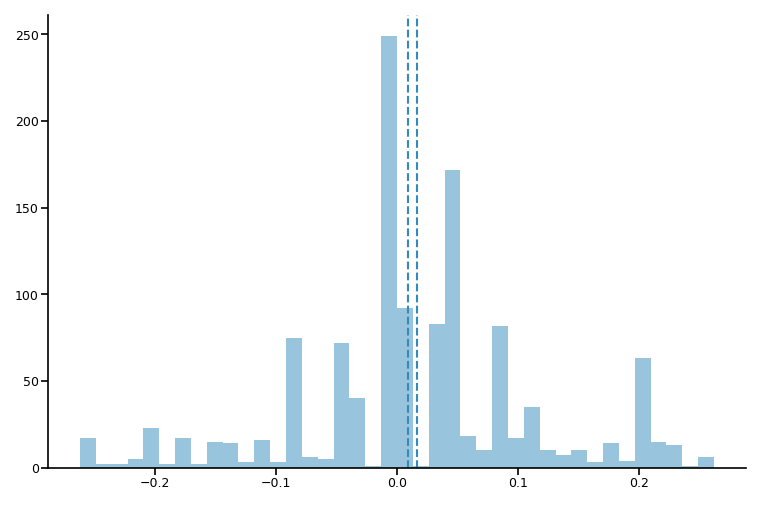

In [22]:
# compute orientation shifts between cells in the same environment (to confirm that the shif statistic is not biased)
orietations_between_cells01 = np.array([calculate_orientation_shift(ratemaps[0,i], ratemaps[0,j]) for i in range(50) for j in range(i+1,50)])

orietations_between_cells01_circular = orietations_between_cells01 % (np.pi/6)
orietations_between_cells01_circular = np.concatenate([orietations_between_cells01_circular, orietations_between_cells01_circular+np.pi/6, orietations_between_cells01_circular-np.pi/6])

plt.hist(orietations_between_cells01_circular, bins=40, alpha=0.5, label='0->1', range=(-np.pi/12,np.pi/12))
maskbetween01 = (orietations_between_cells01_circular > -np.pi/12) & (orietations_between_cells01_circular < np.pi/12)
print(np.nanmedian(orietations_between_cells01_circular[maskbetween01])*180/np.pi)
print(np.nanmean(orietations_between_cells01_circular[maskbetween01])*180/np.pi)
print(np.nanstd(orietations_between_cells01_circular[maskbetween01])*180/np.pi)
print(np.nanstd(orietations_between_cells01_circular[maskbetween01])/np.sqrt(np.sum(maskbetween01))*180/np.pi)
plt.axvline(np.nanmedian(orietations_between_cells01_circular[maskbetween01]),ls='--')
plt.axvline(np.nanmean(orietations_between_cells01_circular[maskbetween01]),ls='--')

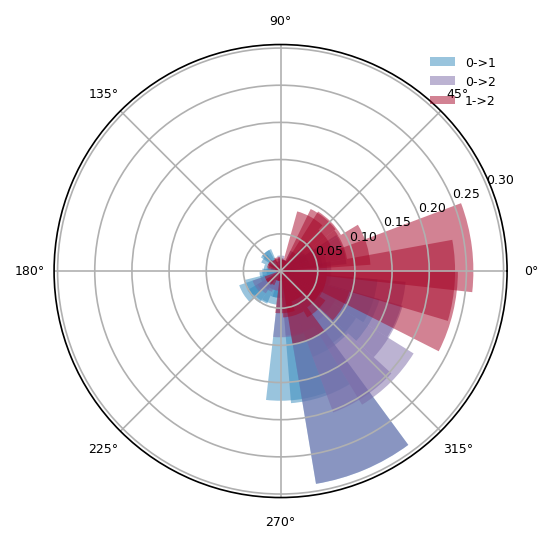

In [23]:
fig,ax = plt.subplots(subplot_kw={'projection':'polar'})
ax.hist(orientations01_circular*12, bins=40, density=True, alpha=0.5, label='0->1')
ax.hist(orientations02_circular*12, bins=40, density=True, alpha=0.5, label='0->2')
ax.hist(orientations12_circular*12, bins=40, density=True, alpha=0.5, label='1->2')
ax.legend()

## Calculate spacing

In [24]:
spacings = np.zeros(ratemaps.shape[:2])
for i in range(ratemaps.shape[0]):
    for j in range(ratemaps.shape[1]):
        spacings[i,j] = grid_spacing(ratemaps[i,j])[0]
print(np.isnan(spacings).sum())

3


[0.88411986 0.83988488 0.85018281] 0.8560898882123422


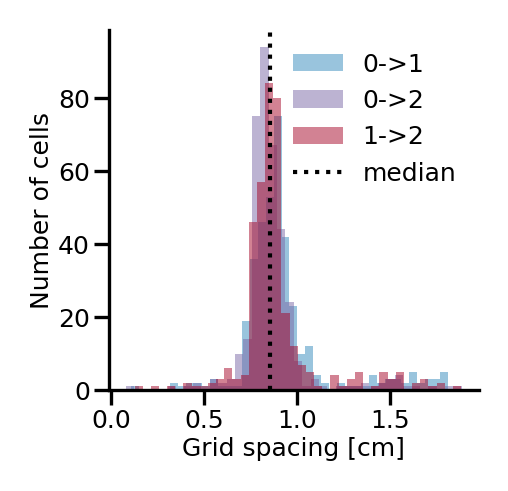

In [33]:
fig, ax = plt.subplots(figsize=figsize, dpi=300)
ax.hist(spacings[0], bins=40, alpha=0.5, label='0->1')
ax.hist(spacings[1], bins=40, alpha=0.5, label='0->2')
ax.hist(spacings[2], bins=40, alpha=0.5, label='1->2')
ax.axvline(np.nanmedian(spacings), color='k', ls=':', label='median')
ax.legend()
ax.set_xlabel('Grid spacing [cm]')
ax.set_ylabel('Number of cells')
print(np.nanmedian(spacings,axis=1), np.nanmedian(spacings))
fig.savefig(experiment.paths['experiment'] / "plots/grid_spacing")